### **Importing Required Libraries**

In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go
# Importing libraries for performing Natural Language Processing on 'Restaurant_Reviews.tsv' dataset
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('ignore')

### **Loading the Dataset**

In [2]:
# Loading the dataset
df = pd.read_csv('./Restaurant_Reviews.tsv', delimiter='\t', quoting=3)

In [3]:
# Lets check the first five rows of data
df.head()

Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1

In [4]:
# Shape
df.shape

(1000, 2)

In [5]:
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

**data is equally distributed between liked and disliked**

### **EDA**

In [6]:
Labels = pd.DataFrame(df['Liked'].value_counts()).reset_index()
Labels.columns = ['Liked','Count']
Labels['Liked'] = Labels['Liked'].map({0: 'Negative',1: 'Positive'})

fig = px.pie(Labels, values = 'Count', names = 'Liked', title='Percentage of reviews', hole=.4, color = 'Liked',
             width=800, height=400)
fig.show()

#### Let's see the most used words in positive reviews!

In [7]:
positive_reviews = df[df["Liked"] == 1]

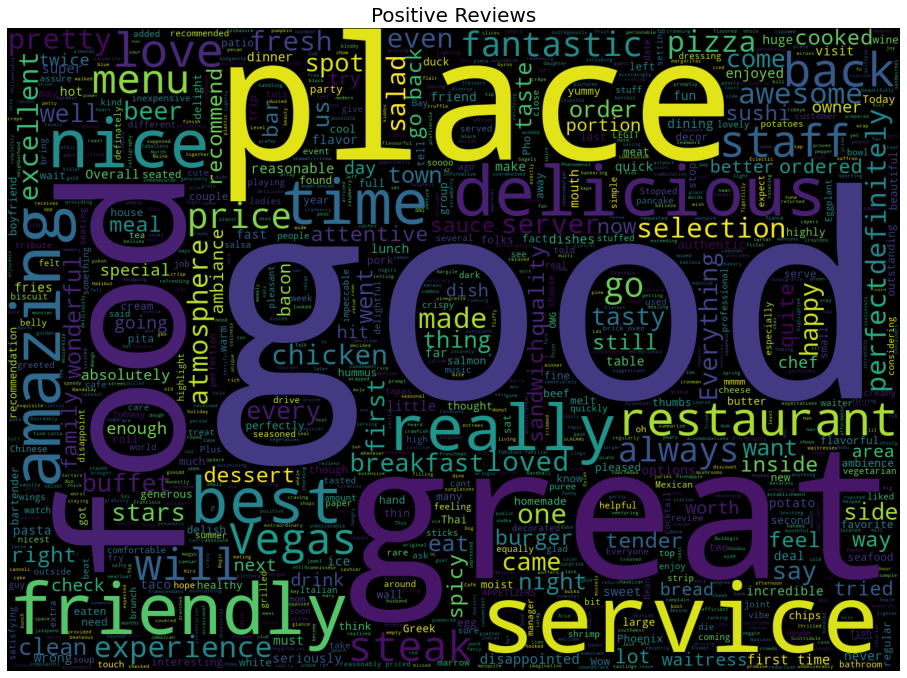

In [8]:
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='black',max_words = 10000,
                          width=1500, stopwords=STOPWORDS,
                          height=1080
                         ).generate(" ".join(positive_reviews.Review))
plt.title("Positive Reviews", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

#### Now Let's see the most used words in negative reviews!

In [9]:
negative_reviews = df[df["Liked"] == 0]

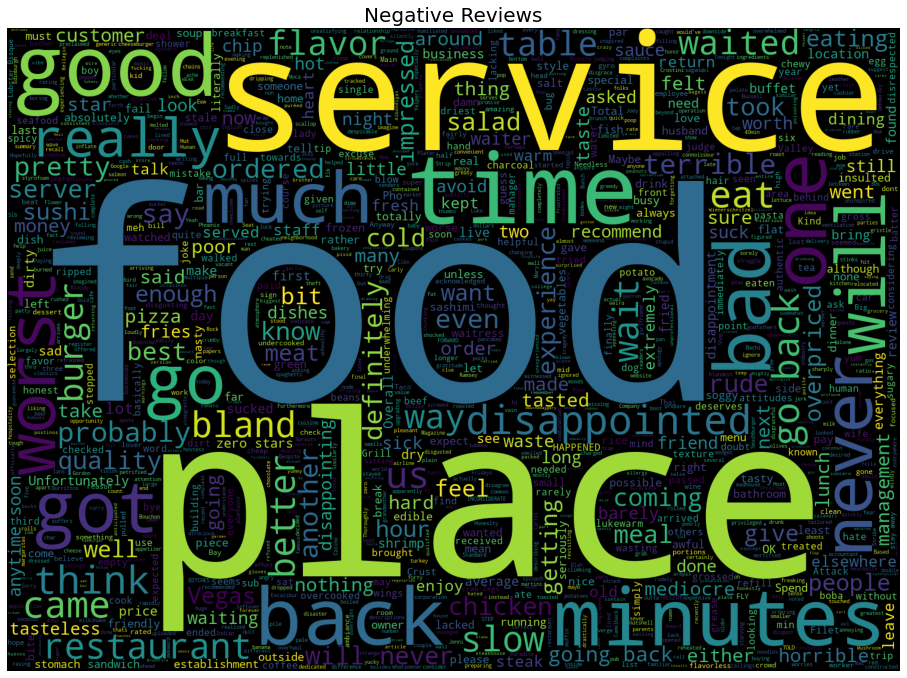

In [10]:
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='black',max_words = 10000,
                          width=1500, stopwords=STOPWORDS,
                          height=1080
                         ).generate(" ".join(negative_reviews.Review))
plt.title("Negative Reviews", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

### **Data Preprocessing**

In [11]:
# Here we get the length of each review
df['Length']= df['Review'].apply(len) 
df.head()

Review  Liked  Length
0                           Wow... Loved this place.      1      24
1                                 Crust is not good.      0      18
2          Not tasty and the texture was just nasty.      0      41
3  Stopped by during the late May bank holiday of...      1      87
4  The selection on the menu was great and so wer...      1      59

In [12]:
# Cleaning the reviews
corpus = []
for i in range(0,len(df)):
    

    # Cleaning special character from the reviews
    review = re.sub(pattern='[^a-zA-Z]',repl=' ', string=df['Review'][i])

    # Converting the entire review into lower case
    review = review.lower()

    # Tokenizing the review by words
    review_words = review.split()

    # Removing the stop words
    review_words = [word for word in review_words if not word in set(stopwords.words('english'))]

    # Stemming the words
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review_words]

    # Joining the stemmed words
    review = ' '.join(review)

    # Creating a corpus
    corpus.append(review)

In [13]:
# lets check the corpus
corpus[0:5]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

### **Bag of Words**

In [14]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.loc[:, 'Liked'].values

### **Model Building**

**Train-Test Split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [16]:
# Model building function
def Model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model,accuracy

In [17]:
result = pd.DataFrame(columns = ["Model", "Accuracy"])

models = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(n_estimators=1000),
                      KNeighborsClassifier(n_neighbors = 7, metric = "minkowski", p = 2),
                      SVC(kernel = 'rbf'), GaussianNB(), XGBClassifier(n_estimators=300, learning_rate=0.01)]

for model in models:
    clf, accuracy = Model(model)
    result = result.append({"Model": model, "Accuracy": accuracy}, ignore_index=True)

result

Model  Accuracy
0                           DecisionTreeClassifier()     0.660
1                               LogisticRegression()     0.770
2  (DecisionTreeClassifier(max_features='auto', r...     0.695
3                KNeighborsClassifier(n_neighbors=7)     0.660
4                                              SVC()     0.775
5                                       GaussianNB()     0.690
6  XGBClassifier(base_score=0.5, booster='gbtree'...     0.745

**Logistic Regression and SVM performed better here.**

In [18]:
# Fitting svm to the Training set
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC()

### **Prediction**

In [19]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

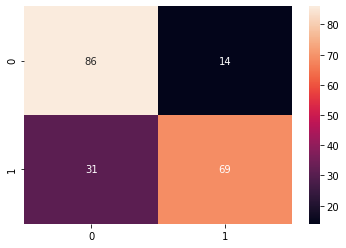

In [20]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)
plt.show()

### Tuning the hyper-parameters of SVM

In [21]:
# Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

# Create a GridSearchCV object and fit it to the training data
grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [22]:
# Find the optimal parameters
print(grid.best_estimator_)

SVC(C=100, gamma=0.001)


In [23]:
# Find the best score
print(grid.best_score_)

0.77


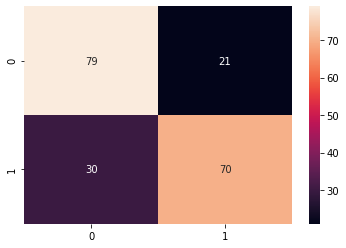

In [24]:
pred = grid.predict(X_test)
# Making the Confusion Matrix
cm1 = confusion_matrix(y_test, pred)
sns.heatmap(cm1,annot=True)
plt.show()

In [25]:
# Helper Function for prediction
def predict_sentiment(sample_review):
    sample_review = re.sub(pattern='[^a-zA-Z]',repl=' ', string = sample_review)
    sample_review = sample_review.lower()
    sample_review_words = sample_review.split()
    sample_review_words = [word for word in sample_review_words if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    final_review = [ps.stem(word) for word in sample_review_words]
    final_review = ' '.join(final_review)

    temp = cv.transform([final_review]).toarray()
    return grid.predict(temp)

In [26]:
# Predicting values
sample_review = 'The food is really good here.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [27]:
# Predicting values
sample_review = 'Food was pretty bad and the service was very slow.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a NEGATIVE review!


In [28]:
# Predicting values
sample_review = 'The food was absolutely wonderful, from preparation to presentation, very pleasing.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a POSITIVE review.


In [29]:
# Predicting values
sample_review = 'The food was disastrous.'

if predict_sentiment(sample_review):
    print('This is a POSITIVE review.')
else:
    print('This is a NEGATIVE review!')

This is a NEGATIVE review!


In [31]:
# Creating a pickle file for the CountVectorizer
import pickle
pickle.dump(cv, open('cv-transform.pkl', 'wb'))

In [32]:
# Creating a pickle file for the Multinomial Naive Bayes model
filename = 'restaurant-sentiment-mnb-model.pkl'
pickle.dump(grid, open(filename, 'wb'))